In [1]:
import re
import os
import random
import requests as req
from tqdm import tqdm
import pandas as pd
import json
from constants import KAGGLE_HERBARIUM_22_TRAIN_CSV # This is where the dataset is stored

df = pd.read_csv(KAGGLE_HERBARIUM_22_TRAIN_CSV).drop(columns=["Unnamed: 0"])
print(df.columns)

output_file = "wiki_descriptions.json"

labels = (df["genus"] + " " + df["species"]).unique().tolist()
df["label"] = df["genus"] + " " + df["species"]

print(f"Number of unique species (labels): {len(labels)}")
print(f"Labels: {labels[:5]}")

Index(['image_id', 'filename', 'label', 'species', 'genus', 'family'], dtype='object')
Number of unique species (labels): 15501
Labels: ['Abies amabilis', 'Abies balsamea', 'Abies bracteata', 'Abies concolor', 'Abies fraseri']


In [2]:
df.head()

,image_id,filename,label,species,genus,family
0,00000__001,000/00/00000__001.jpg,Abies amabilis,amabilis,Abies,Pinaceae
1,00000__002,000/00/00000__002.jpg,Abies amabilis,amabilis,Abies,Pinaceae
2,00000__003,000/00/00000__003.jpg,Abies amabilis,amabilis,Abies,Pinaceae
3,00000__004,000/00/00000__004.jpg,Abies amabilis,amabilis,Abies,Pinaceae
4,00000__005,000/00/00000__005.jpg,Abies amabilis,amabilis,Abies,Pinaceae


In [3]:
df[df["image_id"]=="08033__100"]

,image_id,filename,label,species,genus,family
435131,08033__100,080/33/08033__100.jpg,Keckiella cordifolia,cordifolia,Keckiella,Plantaginaceae


In [14]:
questions = [
    "Describe the image concisely.",
    "Provide a brief description of the given image.",
    "Offer a succinct explanation of the picture presented.",
    "Summarize the visual content of the image.",
    "Give a short and clear explanation of the subsequent image.",
    "Share a concise interpretation of the image provided.",
    "Present a compact description of the photo’s key features.",
    "Relay a brief, clear account of the picture shown.",
    "Render a clear and concise summary of the photo.",
    "Write a terse but informative summary of the picture.",
    "Create a compact narrative representing the image presented."
]


In [15]:
dataset = json.load(open("descriptions-dataset.json", "r"))

pretrain_dataset = []

print(dataset[0])

{'id': 'e3ee51ea-7057-4329-94c1-685aebf6058a', 'species': 'Eleocharis vivipara', 'caption': 'Species name: Eleocharis vivipara | Common Name: Umbrella hairgrass | Leaves/Petals: Green, thin, smooth | Habitat: Margins of ponds, marshes, and ditches in the southern United States', 'conversations': [{'from': 'human', 'value': 'Can you describe what the stems of Eleocharis vivipara look like in the image?'}, {'from': 'assistant', 'value': 'The stems appear slender and cylindrical, forming a clump. They seem to have a vibrant green color, possibly with a hint of reddish tint at the base. This gives them a delicate yet striking appearance.'}, {'from': 'human', 'value': 'What can you tell me about the flowers in the image?'}, {'from': 'assistant', 'value': 'The flowers at the top of the stems are small and clustered, creating a unique spike-like structure. They likely give off a soft, feathery appearance that contributes to the overall aesthetic of the plant, resembling an umbrella.'}, {'from

## Create a pre-train dataset for feature alignment

In [ ]:
for sample in dataset:
    species = sample["species"]
    d = {}
    d["id"] = sample["id"]
    d["conversations"] = []
    d["image"] = df[df["label"] == species]["filename"].sample(1).values[0]

    question = random.choice(questions)

    if random.random() > 0.5:
        question = question + "\n<image>"
    else:
        question = "<image>\n" + question
        
    caption = sample['caption']

    d["conversations"].append({
        "from": "human",
        "value": question,
    })

    d["conversations"].append({
        "from": "gpt",
        "value": caption,
    })

    pretrain_dataset.append(d)

# save
with open("pretrain_dataset.json", "w") as f:
    json.dump(pretrain_dataset, f, indent=4)

In [ ]:
pretrain_dataset[0]

{'id': 'e3ee51ea-7057-4329-94c1-685aebf6058a',
 'conversations': [{'from': 'human',
   'value': '<image>\nShare a concise interpretation of the image provided.'},
  {'from': 'assistant',
   'value': 'Species name: Eleocharis vivipara | Common Name: Umbrella hairgrass | Leaves/Petals: Green, thin, smooth | Habitat: Margins of ponds, marshes, and ditches in the southern United States'}],
 'image': '052/95/05295__068.jpg'}

### Create a finetuning dataset for Visual Instruction Tuning

In [27]:
for sample in dataset:
    species = sample["species"]
    d = {}
    d["id"] = sample["id"]
    d["conversations"] = []
    d["image"] = df[df["label"] == species]["filename"].sample(1).values[0]

    question = random.choice(questions)

    if random.random() > 0.5:
        question = question + "\n<image>"
    else:
        question = "<image>\n" + question
        
    caption = sample['caption']

    if type(sample['conversations'][0]) is list:
        sample['conversations'] = sample['conversations'][0]

    print(sample['conversations'])

    for turn in sample['conversations']:
        if type(turn) is list:
            turn = turn[0]
        if turn["from"] == "assistant":
            turn["from"] = "gpt"
        d["conversations"].append(turn)

    pretrain_dataset.append(d)

# save
with open("finetune_dataset.json", "w") as f:
    json.dump(pretrain_dataset, f, indent=4)

[{'from': 'human', 'value': 'Can you describe what the stems of Eleocharis vivipara look like in the image?'}, {'from': 'assistant', 'value': 'The stems appear slender and cylindrical, forming a clump. They seem to have a vibrant green color, possibly with a hint of reddish tint at the base. This gives them a delicate yet striking appearance.'}, {'from': 'human', 'value': 'What can you tell me about the flowers in the image?'}, {'from': 'assistant', 'value': 'The flowers at the top of the stems are small and clustered, creating a unique spike-like structure. They likely give off a soft, feathery appearance that contributes to the overall aesthetic of the plant, resembling an umbrella.'}, {'from': 'human', 'value': 'Does the image show any young plantlets, and if so, how do they appear?'}, {'from': 'assistant', 'value': "Yes, the image may showcase young plantlets emerging from the spikes. These plantlets would typically look similar to the main stems but smaller, indicating the plant's

## For image viewing

/projectnb/herbdl/data/kaggle-herbaria/herbarium-2022/train_images/052/95/05295__068.jpg


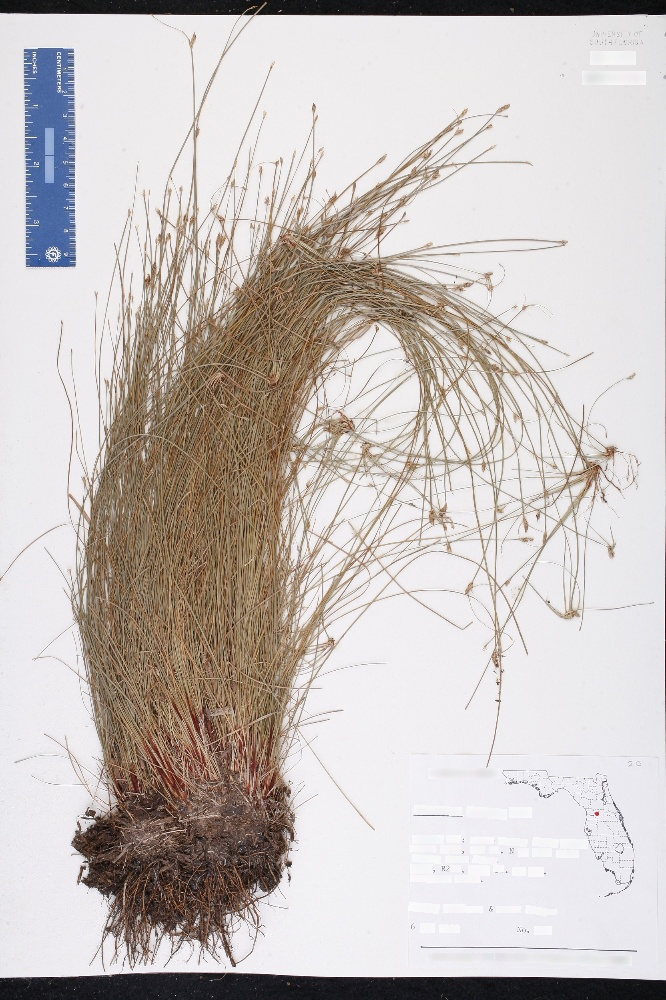

In [14]:
from constants import KAGGLE_HERBARIUM_22_TRAIN

image = '052/95/05295__068.jpg'
path = os.path.join(KAGGLE_HERBARIUM_22_TRAIN, image)
print(path)

from IPython.display import Image
Image(path)

In [28]:
import json

dataset = json.load(open("finetune_dataset.json", "r"))


for sample in dataset:
    try:
        sum(len(conv['value'].split()) for conv in sample['conversations'])
    except:
        print(sample['conversations'])